<a href="https://colab.research.google.com/github/btcrabb/Curriculum-Modeling/blob/main/Radiology_Curriculum_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Modeling Interleaved Radiology Curriculums with Machine Learning

Author: Brendan Crabb

Email: brendan.crabb@hsc.utah.edu

Hypothesis: Based on the concept of contextual interference in human learners, we hypothesize that a multi-task neural network may benefit from increased between skill variability during optimization. Secondly, due to the similarities in learning, curriculum changes for human learners can be rapidly simulated using neural networks.

We will investigate this hypothesis by evaluating model convergence, overall accuracy, and generalization capability following optimization with several different training schedules. Primarily, we will investigate a blocked training schedule (control) vs an interleaved training schedule (intervention). If these concepts prove to be true in neural networks as well as humans, the CNN could be used to rapidly model and test potential curriculum changes for radiology residents. 

This notebook was made running Tensorflow 2.8.2 on Google Colab. To get started, we import the necessary libraries and ensure that we have an appropriate runtime by checking the number of available GPUs.

In [ ]:
import os
print(os)

<module 'os' from '/usr/lib/python3.8/os.py'>


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

from sklearn.utils import class_weight
import os
import time

import seaborn as sns
import sklearn
import sklearn.metrics
from sklearn.model_selection import StratifiedKFold
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

2.8.2
Num GPUs Available:  1


In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Aug 20 15:44:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    24W / 300W |      2MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

The data for this project is currently stored on google drive. We can load and access data on drive by mounting it to this runtime.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


#### 1.0 Model Initialization

In the below cell, we define a function to build and initialize our neural network. By wrapping this cell in a function, we can reinitialize our model each time we change our training schedule.

The model architecture is currently based on the successful and widely used ResNet50 architecture. Moreover, we download this model with pre-trained feature extraction layers with weights from the Imagenet dataset.

Additionally, due to the limited size of the current dataset, we add several preprocessing layers to perform real-time data augmentation during training. These augmentations currently consist of random horizontal flips and random translation.

In [ ]:
def initialize_model():

  """ Function that creates and initializes a ResNet50 model """

  # define input layer
  input_tensor = tf.keras.layers.Input((224,224,3), name='inputs')

  # Add preprocessinga and data augmentation layers
  pre = tf.cast(input_tensor, tf.float32)
  #pre = norm_layer(pre)
  aug = tf.keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal')(pre)
  aug = tf.keras.layers.Resizing(256, 256)(aug)
  aug = tf.keras.layers.experimental.preprocessing.RandomTranslation(0.1, 0.1, fill_mode='constant', fill_value=0.0)(aug)
  aug = tf.keras.layers.CenterCrop(224,224)(aug)
  
  processed_input = tf.keras.applications.resnet50.preprocess_input(aug)

  # Define the base model!
  base_model = tf.keras.applications.resnet50.ResNet50(
          input_shape=(224,224,3),
          include_top=False,
          weights='imagenet',
      )
  
  # add a global spatial average pooling layer
  x = base_model(processed_input)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dropout(0.20)(x)

  # add a logistic layer for 4 classes
  predictions = tf.keras.layers.Dense(4, activation='softmax')(x)

  # build trainable model, this is the model we will train
  model = tf.keras.models.Model(inputs=input_tensor, outputs=predictions)

  # freeze/unfreeze pretrained layers
  for i, layer in enumerate(base_model.layers):
    layer.trainable = False

  return model

In [ ]:
# test our initialization function and show which layers are frozen/trainable
model = initialize_model()

for layer in model.layers:
  print(layer.name, layer.trainable)

94781440/94765736 [==============================] - 0s 0us/step
inputs True
tf.cast True
random_flip True
resizing True
random_translation True
center_crop True
tf.__operators__.getitem True
tf.nn.bias_add True
resnet50 True
global_average_pooling2d True
dropout True
dense True


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 224, 224, 3)]     0         
                                                                 
 tf.cast (TFOpLambda)        (None, 224, 224, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 resizing (Resizing)         (None, 256, 256, 3)       0         
                                                                 
 random_translation (RandomT  (None, 256, 256, 3)      0         
 ranslation)                                                     
                                                                 
 center_crop (CenterCrop)    (None, 224, 224, 3)       0         
                                                             

2.0 Dataset Loading Partitioning

The JSRT, ChestX-ray14, and CBIS-DDSM cases being used in the project can be loaded directly from Google Drive using the Tensorflow/keras .image_dataset_from_directory() function. In the following cell, we load our training and testing datasets for both the CXR and mammography cases. 

Dataset curation was performed separately, so all we need to do in this notebook is import the datasets. Due to the fact that we will be performing stratified k-fold cross validation, we only need a training and testing dataset here.


In [ ]:
# dataset parameters
batch_size = 8 # a batch size of 8 was used for all datasets
img_height = 224 # since we are using pre-trained weights from ImageNet, we are forced to use 224 x 224 x 3 images. 
img_width = 224

# load testing dataset (same cases as the post-test for the human subject experiment)
testing_dir = '/content/drive/MyDrive/Research/RadResidentTraining/processed/PostTest/'
post_test_ds = tf.keras.utils.image_dataset_from_directory(
            testing_dir,
            seed=123,
            image_size=(img_height, img_width),
            batch_size=batch_size,
            color_mode='rgb',
            interpolation='bicubic')

# configure ds for performance
AUTOTUNE = tf.data.AUTOTUNE
test_ds = post_test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 40 files belonging to 4 classes.


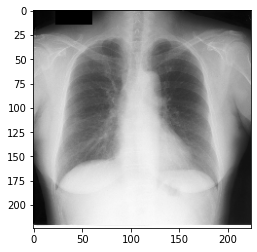

In [ ]:
# display one of the test images to verify the dataset has been loaded approapriately 
for image, label in test_ds.take(1):

  img = np.array(image).astype(np.uint8)
  plt.figure()
  plt.imshow(img[0,:,:,:], cmap='gray')
  plt.show()

In [ ]:
# load training dataset
# in order to adjust the labels and load both CXR and mammographic images, we will use a custome function, as opposed to the approach above
PATH = '/content/drive/MyDrive/Research/RadResidentTraining/processed/mammo/train/'
X_mammo = []
Y_mammo = []
for (root, subdir, files) in os.walk(PATH):
  for file in files:

    # add image to mammo list
    X_mammo.append(np.array(Image.open(os.path.join(root,file)).resize((224,224), Image.BICUBIC).convert('RGB')))

    # add target label
    if 'normal' in root.split('/'):
      Y_mammo.append(3)
    elif 'abnormal' in root:
      Y_mammo.append(0)
    else:
      print('hmmmmmm.... thats very odd.')

print(len(X_mammo))
print(len(Y_mammo))

2560
2560


In [ ]:
# load chest radiograph images from directory:
PATH = '/content/drive/MyDrive/Research/RadResidentTraining/processed/cxr/train/'
X_cxr = []
Y_cxr = []
for (root, subdir, files) in os.walk(PATH):
  for file in files:

    # add image to mammo list
    X_cxr.append(np.array(Image.open(os.path.join(root,file)).resize((224,224)).convert('RGB')))

    # add target label
    if 'nodule' in root.split('/'):
      Y_cxr.append(1)
    elif 'non_nodule' in root:
      Y_cxr.append(2)
    else:
      print('hmmmmmm.... thats very odd.')

print(len(X_cxr))
print(len(Y_cxr))

2560
2560


In [ ]:
# convert lists to numpy arrays
X_mammo = np.array(X_mammo)
Y_mammo = np.array(Y_mammo)

X_cxr = np.array(X_cxr)
Y_cxr = np.array(Y_cxr)

#### 3.0 Weight Balancing

Early in the project the dataset was unbalanced (i.e., there was a different number of cases in each class). Consequently, we needed to apply class weights to adjust our loss function. We can calculate these by simply computing the frequency of each class currently in our training dataset. 

However, in the final project, the classes were balanced so this became unnecessary. Regardless, it is nice to check that the classes are balanced.

In [ ]:
# Calculate class weights
labels = np.concatenate([y for x, y in test_ds], axis=0)

class_weights = class_weight.compute_class_weight(
                                                class_weight = "balanced",
                                                classes = np.unique(labels),
                                                y = labels   
                                                  )

In [ ]:
# display class weights as dictionary (dict is necessary for use with keras)
class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

{0: 1, 1: 1, 2: 1, 3: 1}

In [ ]:
# Extract class names
classes = ['Normal Mammo', 'Abnormal Mammo', 'Nodule', 'Non-nodule']

#### 4.0 Histogram Equalization

The image provided through JSRT are relatively low contrast; consequently, many previous projects that have attempted nodule detection on this dataset have employed contrast enhancements. This is primarily accomplished through adaptive histograme equalization, which can be implemented with OpenCV's CLAHE (Contrast Limited Adaptive Histogram Equalization). We will adjust all of the images accordingly prior to training.

NOTE - This was note used in the final iteration of the project; however, it is a useful function to have if needed.

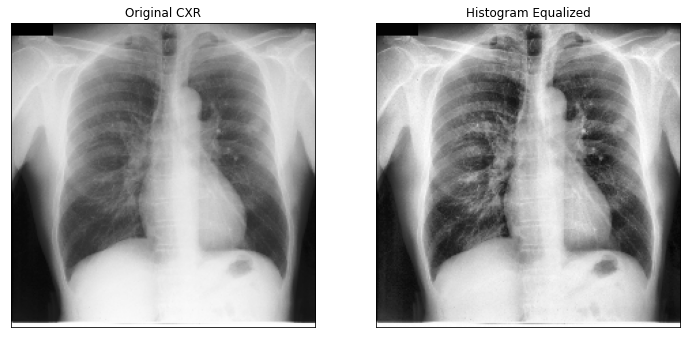

In [ ]:
import cv2

# get first image
for cxr, _ in cxr_test_ds.take(1):
  cxr_img = np.array(tf.squeeze(cxr))

cxr_img = cxr_img[0,:,:,:]

# adjust to uint8 image
cxr_img = cxr_img / np.max(cxr_img)
cxr_img = cxr_img * 255
cxr_img = cxr_img.astype(np.uint8)

R, G, B = cv2.split(cxr_img)

# create a CLAHE object (Arguments are optional).
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
output1_R = clahe.apply(R)
output1_G = clahe.apply(G)
output1_B = clahe.apply(B)

equ = cv2.merge((output1_R, output1_G, output1_B))

# display side by side comparison
plt.figure(figsize=(12,6))
ax = plt.subplot(1,2,1)
ax.imshow(cxr_img, cmap='gray')
ax.set_title('Original CXR')
ax.set_xticks([])
ax.set_yticks([])

ax2 = plt.subplot(1,2,2)
ax2.imshow(equ, cmap='gray')
ax2.set_title('Histogram Equalized')
ax2.set_xticks([])
ax2.set_yticks([])

plt.show()

In [ ]:
# create function to apply to training dataset
def equalize_hist(img):

  """
  Applies CLAHE to an image.
  @param: img: the input image
  returns: equalized image (as tf tensor)
  """

  # create a CLAHE object (Arguments are optional).
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  out= clahe.apply(img)

  return out

In [ ]:
# apply equalization to cxr datasets
PATH = '/content/drive/MyDrive/RadResidentTraining/processed/cxr/'
for (root, subdirs, files) in os.walk(PATH):
  for file in files:
    img = cv2.imread(os.path.join(root, file), 0)
    out = equalize_hist(img)
    #cv2.imwrite(os.path.join(root, file), out) # only run this once! and be sure to reload datasets

#### 5.0 Optimization Metrics and Functions

For optimization we will utilize a weighted sparse categorical crossentropy loss function. This is accomplished by multipling our computed loss from our output layer (softmax_cross_entropy_with_logits) by the calculated class frequency weights.

We also define a training and testing step. Since we will be varying the training schedule, we need to define our own optimization steps instead of relying on the built-in Tensorflow training steps. In this way, we can control the order in which cases are presented to the neural network.

In [ ]:
# Prepare the metrics.
def weighted_sparse_categorical_crossentropy(labels, logits, weights):
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, logits)
    class_weights_temp = tf.gather(weights, labels)
    return tf.math.multiply(tf.cast(class_weights_temp, tf.float64), tf.cast(loss, tf.float64))

train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = keras.metrics.SparseCategoricalAccuracy()

In [ ]:
#@tf.function # enables eager execution for the training step
def train_step(model, x, y, weights):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        #loss_value = weighted_sparse_categorical_crossentropy(y, logits, weights)
        loss_value = tf.nn.sparse_softmax_cross_entropy_with_logits(y, logits)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_acc_metric.update_state(y, logits)
    return loss_value

In [ ]:
#@tf.function
def test_step(model, x, y):
    val_logits = model(x, training=False)
    val_acc_metric.update_state(y, val_logits)

#### 6.0 Optimization Step

In the below cell, we define a custom optimization step. The code will use each specified training block size model optimization for a given number of epochs. The cases are presented sequentially. For example, if the training block size is 10, 10 batches of mammography cases will be presented to the model, followed by 10 batches of CXR cases. 

At the end of each epoch, we calculate intermediate performance on the validation dataset to track model convergence and training efficiency. These results can be used to investigate how quickly the model is learning. 

Following training, we will evaluate the model on the final held-out test set to investigate overall performance and generalizability. 

In [ ]:
import tqdm 
import pandas as pd

# training block parameters
training_block_size= [1, 260] # for the final project, we used a block size of 1 (fully randomized batches) and 260 (blocked training)

# cross validation parameters
n_splits = 5

# consistent parameters
epochs = 50
target_epoch = 15 # when to unfreeze layers
initial_learning_rate = 5e-3
batch_size = 8

# initiate model
new_model = initialize_model()
new_model.save_weights('/content/drive/MyDrive/Research/RadResidentTraining/models/model-full-3.h5') # save initial weights

# pass learning rate to optimizer and initialize
optimizer = keras.optimizers.Adam(learning_rate=initial_learning_rate)
new_model.compile(optimizer=optimizer)
config = optimizer.get_config()

output = []
# run optimization loop for each training block size
for block_size in training_block_size:

  cxr_indices = StratifiedKFold(n_splits).split(X_cxr, Y_cxr)

  for fold, indices in enumerate(StratifiedKFold(n_splits).split(X_mammo, Y_mammo)):
    train_index,test_index = indices[0],indices[1]

    for temp, cxr_idx in enumerate(cxr_indices):
      if temp == fold:
        indices = cxr_idx
    cxr_train_index,cxr_test_index = indices[0],indices[1]

    # select mammo cases
    x_train_mammo, x_test_mammo = X_mammo[train_index],X_mammo[test_index]
    y_train_mammo, y_test_mammo = Y_mammo[train_index],Y_mammo[test_index]

    # select cxr cases
    x_train_cxr, x_test_cxr = X_cxr[cxr_train_index], X_cxr[cxr_test_index]
    y_train_cxr, y_test_cxr = Y_cxr[cxr_train_index], Y_cxr[cxr_test_index]

    cxr_train_ds = tf.data.Dataset.from_tensor_slices((x_train_cxr, y_train_cxr))
    cxr_val_ds = tf.data.Dataset.from_tensor_slices((x_test_cxr, y_test_cxr))
    mammo_train_ds = tf.data.Dataset.from_tensor_slices((x_train_mammo, y_train_mammo))
    mammo_val_ds = tf.data.Dataset.from_tensor_slices((x_test_mammo, y_test_mammo))

    # optimize for performance
    cxr_train_ds = cxr_train_ds.repeat(50).shuffle(2000).batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)
    mammo_train_ds = mammo_train_ds.repeat(50).shuffle(2000).batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)

    cxr_val_ds = cxr_val_ds.batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)
    mammo_val_ds = mammo_val_ds.batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)

    # reset optimizer
    optimizer = optimizer.from_config(config)
    new_model.compile(optimizer=optimizer)

    # calculate steps
    steps_per_epoch = int(np.floor(len(x_train_mammo)/(block_size*batch_size)))
    print('\nRunning for {} epochs with {} steps per epoch (block size is {}, fold is {}).'.format(epochs, steps_per_epoch, block_size, fold))

    # initialize lists to hold results
    train_accuracy_list = []
    val_accuracy_list = []
    test_accuracy_list = []
    best_validation = 0

    for epoch in range(epochs):
        #print("\nStart of epoch %d" % (epoch,))
        start_time = time.time()

        for i in tqdm.tqdm(range(steps_per_epoch)):
          # Iterate over the batches of the dataset.
          for step_cxr, (x_cxr_batch_train, y_cxr_batch_train) in enumerate(cxr_train_ds.take(block_size)):
              loss_value = train_step(new_model, x_cxr_batch_train, y_cxr_batch_train, class_weights)

              # Log every 200 batches.
              if step_cxr % 200 == 0:
                  # can calculate summary statistics here if desired
                  #print(model.optimizer.lr)
                  pass


          for step_mammo, (x_mammo_batch_train, y_mammo_batch_train) in enumerate(mammo_train_ds.take(block_size)):
              loss_value = train_step(new_model, x_mammo_batch_train, y_mammo_batch_train, class_weights)
              
              # Log every 200 batches.
              if step_mammo % 200 == 0:
                  # can calculate summary statistics here if desired
                  #print(y_mammo_batch_train) # print first label to check if ds is shuffling appropriately
                  pass

        # Display metrics at the end of each epoch.
        train_acc = train_acc_metric.result()
        #print("Training acc over epoch: %.4f" % (float(train_acc),))
        train_accuracy_list.append(train_acc)

        # Reset training metrics at the end of each epoch
        train_acc_metric.reset_states()

        # Run a validation loop on mammograms at the end of each epoch.
        for x_batch_val, y_batch_val in mammo_val_ds:
            test_step(new_model, x_batch_val, y_batch_val)

        val_acc = val_acc_metric.result()
        val_accuracy_list.append(val_acc)
        val_acc_metric.reset_states()
        #print("Mammo Validation acc: %.4f" % (float(val_acc),))

        # Run a validation loop on cxrs at the end of each epoch.
        for x_batch_val, y_batch_val in cxr_val_ds:
            test_step(new_model, x_batch_val, y_batch_val)

        val_acc = val_acc_metric.result()
        val_accuracy_list.append(val_acc)
        val_acc_metric.reset_states()
        #print("CXR Validation acc: %.4f" % (float(val_acc),))
        #print("Time taken: %.2fs" % (time.time() - start_time))

        # check if the validation performance is best
        if val_accuracy_list[-1] > best_validation:
          best_validation = val_accuracy_list[-1] # + val_accuracy_list[-2]
          print('Best validation: {}'.format(best_validation))
          best_model = new_model
          path = '/content/drive/MyDrive/Research/RadResidentTraining/models/'
          best_model.save(os.path.join(path, 'resnet50_full3_{}_fold_{}-topvalidation.hdf5'.format(block_size, fold)))


        # unfreeze final convolutional layers after reaching target epoch
        if epoch == target_epoch:
              print('Unfreezing layers..')

              for i, layer in enumerate(new_model.layers):
                  layer.trainable = True

              # Update optimizer / model
              #optimizer.lr = initial_learning_rate / 10
              #new_model.compile(optimizer = keras.optimizers.Adam(learning_rate=initial_learning_rate/10))

    # run over test set
    for x_batch_test, y_batch_test in test_ds:
      test_step(new_model, x_batch_test, y_batch_test)

    test_acc = val_acc_metric.result()
    test_accuracy_list.append(test_acc)
    val_acc_metric.reset_states()

    # save model
    path = '/content/drive/MyDrive/Research/RadResidentTraining/models/'
    best_model.save(os.path.join(path, 'resnet50-full3_{}_fold_{}-topvalidation.hdf5'.format(block_size, fold)))
    new_model.save(os.path.join(path, 'resnet50-full3_{}_fold_{}.hdf5'.format(block_size, fold)))

    # save summary metrics
    output.append([best_model, block_size, train_accuracy_list, val_accuracy_list, test_accuracy_list])

    reports_path = '/content/drive/MyDrive/Research/RadResidentTraining/reports/'
    pd.DataFrame(train_accuracy_list).to_csv(os.path.join(reports_path, 'train_acc-full3_{}_fold_{}.csv'.format(block_size, fold)))
    pd.DataFrame(val_accuracy_list).to_csv(os.path.join(reports_path, 'val_acc-full3_{}_fold_{}.csv'.format(block_size, fold)))
    pd.DataFrame(test_accuracy_list).to_csv(os.path.join(reports_path, 'test_acc-full3_{}_fold_{}.csv'.format(block_size, fold)))

    for i, layer in enumerate(new_model.layers):
      layer.trainable = False
    
    # clear the existing model
    new_model.load_weights('/content/drive/MyDrive/Research/RadResidentTraining/models/model-full-3.h5')

    #print(new_model.summary())

#### 7.0 Evaluation

Now that the models have been optimized, it is time to evaluate their performance on the post-test. In this code block, we load each model, make predictions on the post-test, and save the predictions in a pandas DataFrame.

Evaluation metrics are calculated separately using a mixed effects binomial regression model in R, in order to be consistent with the human subject experiement.

In [ ]:
training_block_size = [1, 260]
out=[]
for i in training_block_size:

  for j in range(5):

    # load model
    path = '/content/drive/MyDrive/Research/RadResidentTraining/models/'
    out_model = tf.keras.models.load_model(os.path.join(path, 'resnet50-full_{}_fold_{}-topvalidation.hdf5'.format(i, j)))

    y_pred = []
    y_true = []

    for image, target in test_ds:
      y = out_model(image)

      for pred in y:
        y_pred.append(np.argmax(pred))
      for tar in target:
        y_true.append(tar.numpy())

    # reorder the predictions and labels
    y_pred_new = []
    for x in y_pred:
      if x == 1:
        y_pred_new.append(3)
      elif x == 3:
        y_pred_new.append(1)
      else:
        y_pred_new.append(x)

    y_true_new = []
    for x in y_true:
      if x == 1:
        y_true_new.append(3)
      elif x == 3:
        y_true_new.append(1)
      else:
        y_true_new.append(x)

    classes = ['Abnormal Mammogram', 'Normal Mammogram', 'CXR Without Nodule', 'CXR With Nodule']

    # Get classification report
    #print('Training Block Size {}'.format(i))
    #print(sklearn.metrics.classification_report(y_true_new, y_pred_new, target_names=classes))

    report = sklearn.metrics.classification_report(y_true_new, y_pred_new, target_names=classes)
    sensitivity = report.split('macro avg')[1].split('       ')[1].split('      ')

    # generate confusion matrix
    cm = sklearn.metrics.confusion_matrix(y_true_new, y_pred_new)

    for k, answer in enumerate(y_true_new):

      if answer == 0 or answer == 3:
        abnormality = 1
      else:
        abnormality = 0

      if answer == y_pred_new[k]:
        correct = 1
      else:
        correct = 0

      out.append([i, j, "Post", abnormality, correct])

df_post = pd.DataFrame(out, columns=['Condition', 'Fold', 'Time', 'Abnormality', 'Correct'])
df_post.head()



In [ ]:
full_results = pd.concat([df_post, df_pre])
full_results.to_csv('/content/drive/MyDrive/Research/RadResidentTraining/reports/cnn_results.csv', index=False)

### Training Controls - Completely Random and By Individual Task

In the following cell blocks we will perform several control tests. First, training with a completely random pattern (maximum interleaving). Secondly, training by each individual task to see if multi-task learning provides additional benefits. 

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import shutil

# training w/ completely random pattern
MODELPATH = '../RadResidentTraining/models/random_pattern_081222.h5'
epochs = 150
target_epoch = 15 # when to unfreeze layers
initial_learning_rate = 1e-3
batch_size = 8

# combine datasets
X_mammo = np.array(X_mammo)
Y_mammo = np.array(Y_mammo)

X_cxr = np.array(X_cxr)
Y_cxr = np.array(Y_cxr)

X_train = np.concatenate([X_mammo, X_cxr])
Y_train = np.concatenate([Y_mammo, Y_cxr])

from datetime import datetime
import os

# Make a dir for our tensorboard; just procedural stuff
try:
    os.mkdir('./tensorboard')
except:
    print('directory exists')

try:
    shutil.rmtree('/tmp/.tensorboard-info/')
    print("REMOVED TENSORBOARD INFO TREE")
except:
    pass

try:
  os.mkdir('../reports/')
  os.mkdir('../reports/logs/')
except:
  print('directory exists')

logdir = os.path.join("../reports/logs/", datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir,
                                                      update_freq = 100,
                                                      histogram_freq=1)
# Tell model to save on improvement on loss
callbacks = [EarlyStopping(monitor='loss', patience=75),
             ModelCheckpoint(filepath=MODELPATH, monitor='val_loss', save_best_only=True),
             tensorboard_callback]

# initiate model
model = initialize_model()

# pass learning rate to optimizer and initialize
optimizer = tf.keras.optimizers.SGD(learning_rate=initial_learning_rate)
model.compile(optimizer=optimizer, 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
config = optimizer.get_config()

directory exists
directory exists


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_dataset = train_dataset.shuffle(5000).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
model.fit(train_dataset,
          epochs=target_epoch,
          shuffle=True,
          validation_data = test_ds,
          validation_freq=1,
          callbacks=callbacks,
          initial_epoch=0)

Epoch 1/15
650/650 [==============================] - 19s 23ms/step - loss: 0.8037 - sparse_categorical_accuracy: 0.5608 - val_loss: 0.7506 - val_sparse_categorical_accuracy: 0.5768
Epoch 2/15
650/650 [==============================] - 15s 22ms/step - loss: 0.7118 - sparse_categorical_accuracy: 0.5998 - val_loss: 0.6853 - val_sparse_categorical_accuracy: 0.5714
Epoch 3/15
650/650 [==============================] - 14s 21ms/step - loss: 0.6854 - sparse_categorical_accuracy: 0.6115 - val_loss: 0.7106 - val_sparse_categorical_accuracy: 0.5804
Epoch 4/15
650/650 [==============================] - 14s 21ms/step - loss: 0.6760 - sparse_categorical_accuracy: 0.6229 - val_loss: 0.7939 - val_sparse_categorical_accuracy: 0.5518
Epoch 5/15
650/650 [==============================] - 14s 21ms/step - loss: 0.6661 - sparse_categorical_accuracy: 0.6292 - val_loss: 0.7199 - val_sparse_categorical_accuracy: 0.5857
Epoch 6/15
650/650 [==============================] - 14s 21ms/step - loss: 0.6534 - spars

In [ ]:
# unfreeze weights
for i, layer in enumerate(model.layers):
  layer.trainable = True

model.compile(optimizer=optimizer, 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

model.fit(train_dataset,
          epochs=epochs,
          shuffle=True,
          validation_data=test_ds,
          validation_freq=1,
          callbacks=callbacks,
          initial_epoch=target_epoch,)

Epoch 16/100
163/163 [==============================] - 27s 139ms/step - loss: 0.8759 - sparse_categorical_accuracy: 0.5569 - val_loss: 0.8017 - val_sparse_categorical_accuracy: 0.5589
Epoch 17/100
163/163 [==============================] - 22s 133ms/step - loss: 0.8172 - sparse_categorical_accuracy: 0.5677 - val_loss: 0.9147 - val_sparse_categorical_accuracy: 0.5214
Epoch 18/100
163/163 [==============================] - 22s 134ms/step - loss: 0.7785 - sparse_categorical_accuracy: 0.5808 - val_loss: 0.8297 - val_sparse_categorical_accuracy: 0.5429
Epoch 19/100
163/163 [==============================] - 22s 133ms/step - loss: 0.7469 - sparse_categorical_accuracy: 0.5969 - val_loss: 0.7731 - val_sparse_categorical_accuracy: 0.5571
Epoch 20/100
163/163 [==============================] - 22s 134ms/step - loss: 0.7381 - sparse_categorical_accuracy: 0.6006 - val_loss: 0.7409 - val_sparse_categorical_accuracy: 0.5786
Epoch 21/100
163/163 [==============================] - 22s 133ms/step - lo